# Maximum Flow Problem

The maximum flow problem situations in which some quantity must be transported through a network with limited capacities, and the goal is to determine how much of that quantity can be sent from a starting point to a destination.




The problem is defined on a directed graph consisting of:

* a **source** vertex (s), where the flow originates,
*   a **sink** vertex (t), where the flow is collected,
* and **edges**, each with a capacity that limits how much flow can pass through it.


A flow assigns a non-negative value to each edge, representing the amount sent along that edge, subject to two conditions:

1. **Capacity constraints** - the flow on an edge cannot exceed its capacity.

2. **Flow conservation** - for every vertex except the source and the sink, the total incoming flow must equal the total outgoing flow.

The objective: maximize the total amount of flow sent from the source to the sink while satisfying these constraints.



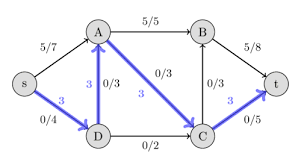

## Main approaches to the Maximum Flow Problem:
 * Linear Programming
 * Ford-Fulkerson Method
 * Dinitz's Method
 * Karzanov Method

### **Linear Programming**

The maximum flow problem can be formulated as a linear programming problem by assigning a variable to the flow on each edge. Capacity constraints limit the value of each variable, and flow conservation constraints ensure that the flow entering and leaving intermediate vertices is equal. The objective is to maximize the total flow into the sink.
This approach is mainly theoretical and is not efficient for large networks.

### **Ford-Fulkerson Method**

The Ford-Fulkerson method starts with zero flow and repeatedly finds augmenting paths from the source to the sink along which additional flow can be sent. The flow is increased along such a path by the smallest available capacity on it. The process stops when no augmenting path exists.
The algorithm is simple and intuitive, but its performance depends on how paths are chosen.

### **Dinic's Algorithm**

Dinic's algorithm improves Ford-Fulkerson by restricting flow to shortest augmenting paths. It first builds a level graph using breadth-first search and then sends as much flow as possible through this graph before rebuilding it.
This significantly reduces unnecessary path searches and makes the algorithm much faster in practice.

### **Karzanov's (Push-Relabel) Method**

Karzanov's method belongs to the push-relabel family of algorithms. Instead of finding paths from the source to the sink, it allows vertices to temporarily hold excess flow and pushes this excess toward the sink using height labels.
Although less intuitive, this approach is very efficient, especially for large or dense graphs.

In [27]:
from collections import defaultdict, deque
import math
import networkx as nx
import matplotlib.pyplot as plt

class WeightedGraph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.weights = {}

    def add_arc(self, u, v, capacity):
        self.graph[u].append(v)
        self.graph[v]  # ensure v exists
        self.weights[(u, v)] = capacity

    def plot(self, title="Graph"):
        G = nx.DiGraph()
        for (u, v), cap in self.weights.items():
            G.add_edge(u, v, capacity=cap)

        pos = nx.spring_layout(G, seed=42)
        labels = nx.get_edge_attributes(G, 'capacity')

        nx.draw(G, pos, with_labels=True,
                node_color='lightblue',
                node_size=2000,
                font_weight='bold',
                arrowsize=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.title(title)
        plt.show()

    def _build_residual_graph(self):
        """
        Creates residual capacity dictionary and adjacency list
        """
        residual = defaultdict(int)
        adj = defaultdict(list)

        for (u, v), cap in self.weights.items():
            residual[(u, v)] += cap
            residual[(v, u)] += 0   # reverse edge
            adj[u].append(v)
            adj[v].append(u)

        return residual, adj

    def max_flow_ford_fulkerson(self, source, sink):
        residual, adj = self._build_residual_graph()
        max_flow = 0

        def dfs(u, flow, visited):
            if u == sink:
                return flow
            visited.add(u)
            for v in adj[u]:
                if v not in visited and residual[(u, v)] > 0:
                    pushed = dfs(v, min(flow, residual[(u, v)]), visited)
                    if pushed > 0:
                        residual[(u, v)] -= pushed
                        residual[(v, u)] += pushed
                        return pushed
            return 0

        while True:
            visited = set()
            pushed = dfs(source, math.inf, visited)
            if pushed == 0:
                break
            max_flow += pushed

        return max_flow

    def max_flow_dinic(self, source, sink):
        residual, adj = self._build_residual_graph()
        max_flow = 0

        while True:
            # BFS: build level graph
            level = {source: 0}
            queue = deque([source])

            while queue:
                u = queue.popleft()
                for v in adj[u]:
                    if v not in level and residual[(u, v)] > 0:
                        level[v] = level[u] + 1
                        queue.append(v)

            if sink not in level:
                break

            # DFS: send flow
            def dfs(u, flow):
                if u == sink:
                    return flow
                for v in adj[u]:
                    if v in level and level[v] == level[u] + 1 and residual[(u, v)] > 0:
                        pushed = dfs(v, min(flow, residual[(u, v)]))
                        if pushed > 0:
                            residual[(u, v)] -= pushed
                            residual[(v, u)] += pushed
                            return pushed
                return 0

            while True:
                pushed = dfs(source, math.inf)
                if pushed == 0:
                    break
                max_flow += pushed

        return max_flow

    def max_flow_push_relabel(self, source, sink):
        residual, adj = self._build_residual_graph()

        height = defaultdict(int)
        excess = defaultdict(int)

        height[source] = len(adj)

        # Preflow
        for v in adj[source]:
            cap = residual[(source, v)]
            if cap > 0:
                residual[(source, v)] -= cap
                residual[(v, source)] += cap
                excess[v] += cap
                excess[source] -= cap

        def push(u, v):
            delta = min(excess[u], residual[(u, v)])
            residual[(u, v)] -= delta
            residual[(v, u)] += delta
            excess[u] -= delta
            excess[v] += delta

        def relabel(u):
            min_height = math.inf
            for v in adj[u]:
                if residual[(u, v)] > 0:
                    min_height = min(min_height, height[v])
            height[u] = min_height + 1

        def discharge(u):
            while excess[u] > 0:
                for v in adj[u]:
                    if residual[(u, v)] > 0 and height[u] == height[v] + 1:
                        push(u, v)
                        if excess[u] == 0:
                            return
                relabel(u)

        nodes = [v for v in adj if v != source and v != sink]

        i = 0
        while i < len(nodes):
            u = nodes[i]
            old_height = height[u]
            discharge(u)
            if height[u] > old_height:
                nodes.insert(0, nodes.pop(i))
                i = 0
            else:
                i += 1

        return excess[sink]


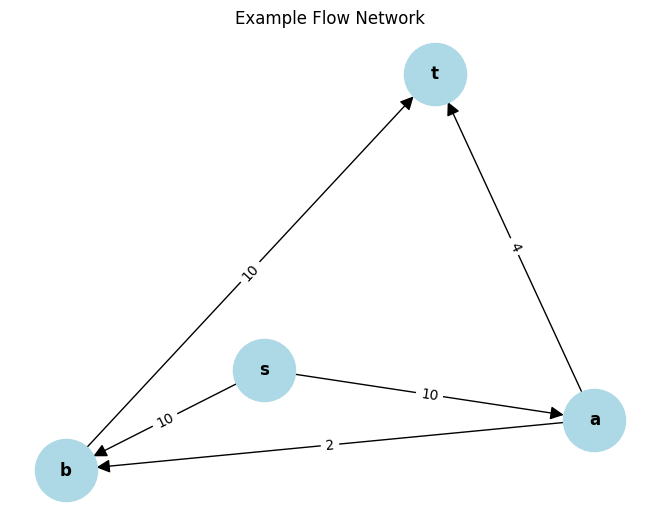

In [28]:
G = WeightedGraph()

G.add_arc('s', 'a', 10)
G.add_arc('s', 'b', 10)
G.add_arc('a', 'b', 2)
G.add_arc('a', 't', 4)
G.add_arc('b', 't', 10)

G.plot("Example Flow Network")


In [29]:
print("Ford–Fulkerson:", G.max_flow_ford_fulkerson('s', 't'))
print("Dinic:", G.max_flow_dinic('s', 't'))
print("Push–Relabel:", G.max_flow_push_relabel('s', 't'))


Ford–Fulkerson: 14
Dinic: 14
Push–Relabel: 14


In [30]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(edges, title):
    G = nx.DiGraph()
    for u, v, cap in edges:
        G.add_edge(u, v, capacity=cap)

    pos = nx.spring_layout(G, seed=1)
    labels = nx.get_edge_attributes(G, 'capacity')

    nx.draw(G, pos, with_labels=True,
            node_color='lightblue',
            node_size=2000,
            arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(title)
    plt.show()


In [31]:
def draw_path(path, title):
    G = nx.DiGraph()
    G.add_edges_from(path)

    pos = nx.spring_layout(G, seed=2)
    nx.draw(G, pos, with_labels=True,
            node_color='lightgreen',
            node_size=2000,
            edge_color='red',
            width=3,
            arrowsize=20)
    plt.title(title)
    plt.show()


Ford-Fulkerson can take any valid path.

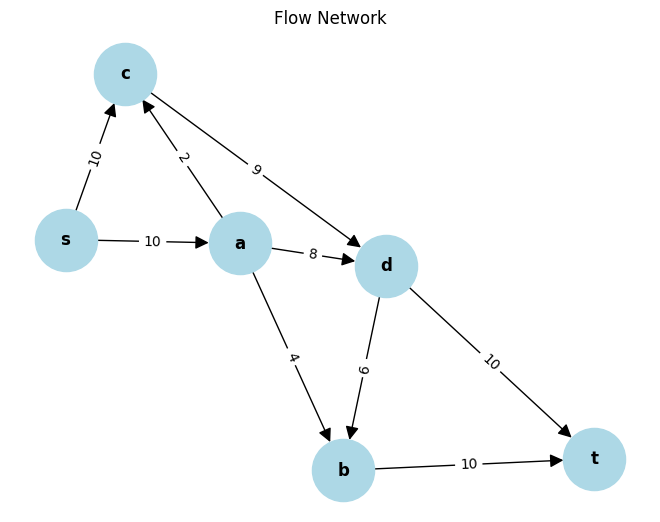

Ford–Fulkerson: 19
Dinic: 19
Push–Relabel: 19


In [32]:
G = WeightedGraph()

G.add_arc('s', 'a', 10)
G.add_arc('s', 'c', 10)
G.add_arc('a', 'b', 4)
G.add_arc('b', 't', 10)
G.add_arc('c', 'd', 9)
G.add_arc('d', 't', 10)
G.add_arc('a', 'd', 8)
G.add_arc('d', 'b', 6)
G.add_arc('a', 'c', 2)

G.plot("Flow Network")
print("Ford–Fulkerson:", G.max_flow_ford_fulkerson('s', 't'))
print("Dinic:", G.max_flow_dinic('s', 't'))
print("Push–Relabel:", G.max_flow_push_relabel('s', 't'))

1. s -9/10-> c -9/9-> d -9/10-> t ==> +9 flow
2. s -4/10-> a -4/4-> b -4/10-> t ==> +4 flow
3. s -10/10-> a -6/8-> d -6/6-> b -10/10-> t ==> + 6 flow

1. s -8/10-> a -8/8-> d -8/10-> t ==> +8 flow
2. s -2/10-> c -2/9-> d -10/10-> t ==> +2 flow
3. s -6/10-> c -6/10-> d -4/8-> a -4/4-> b -4/10-> t ==> +4 flow
4. s -10/10-> a -6/8-> d -2/6-> b -6/10-> t ==> +2 flow
5. s -9/10-> c -9/9-> d -5/6-> b -9/10-> t ==> +3 flow

# Ford-Fulkerson

1. Start with zero flow
2. Find any path from source to sink in the residual graph
3. Push flow equal to the bottleneck (minimum capacity on that path)
4. Update residual graph (reduce forward edges, add backward edges)
5. Repeat until no augmenting path exists

Flow can be sent through:
* **non-full forward edges** (capacity remaining)
* **full backward edges** (to undo previous flow)


# More optimal path choice

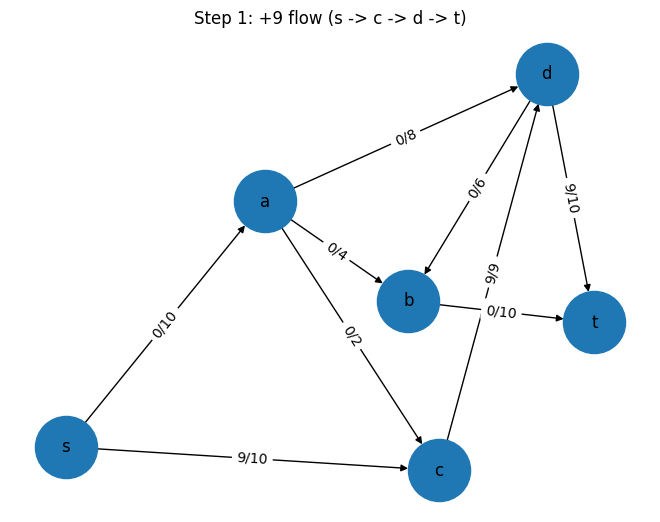

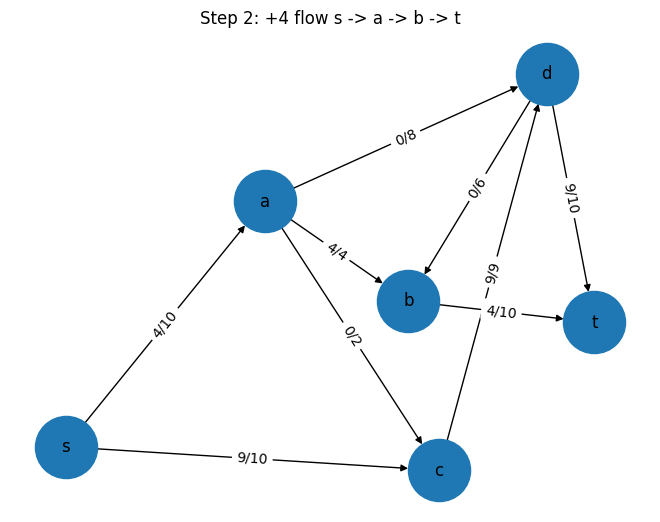

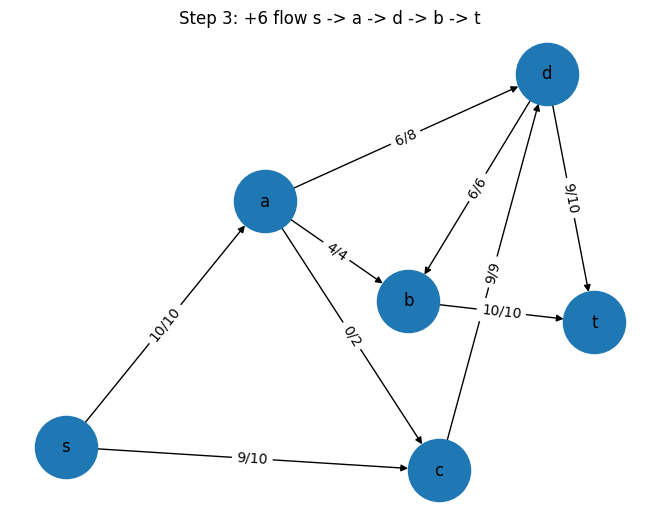

In [33]:


import networkx as nx
import matplotlib.pyplot as plt

edges = [
    ('s','a',10), ('s','c',10),
    ('a','b',4), ('b','t',10),
    ('c','d',9), ('d','t',10),
    ('a','d',8), ('d','b',6),
    ('a','c',2)
]

def draw(flows, title):
    G = nx.DiGraph()
    for u, v, cap in edges:
        f = flows.get((u, v), 0)
        G.add_edge(u, v, label=f"{f}/{cap}")
    pos = nx.spring_layout(G, seed=1)
    plt.figure()
    nx.draw(G, pos, with_labels=True, node_size=2000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    plt.title(title)
    plt.show()

# Step 1: s -> c -> d -> t (push 9)
flow1 = {
    ('s','c'): 9,
    ('c','d'): 9,
    ('d','t'): 9
}
draw(flow1, "Step 1: +9 flow (s -> c -> d -> t)")

# Step 2: s -> a -> b -> t (push 4)
flow2 = {
    **flow1,
    ('s','a'): 4,
    ('a','b'): 4,
    ('b','t'): 4
}
draw(flow2, "Step 2: +4 flow s -> a -> b -> t")

# Step 3: s -> a -> d -> b -> t (push 6)
flow3 = {
    **flow2,
    ('s','a'): 10,
    ('a','d'): 6,
    ('d','b'): 6,
    ('b','t'): 10
}
draw(flow3, "Step 3: +6 flow s -> a -> d -> b -> t")


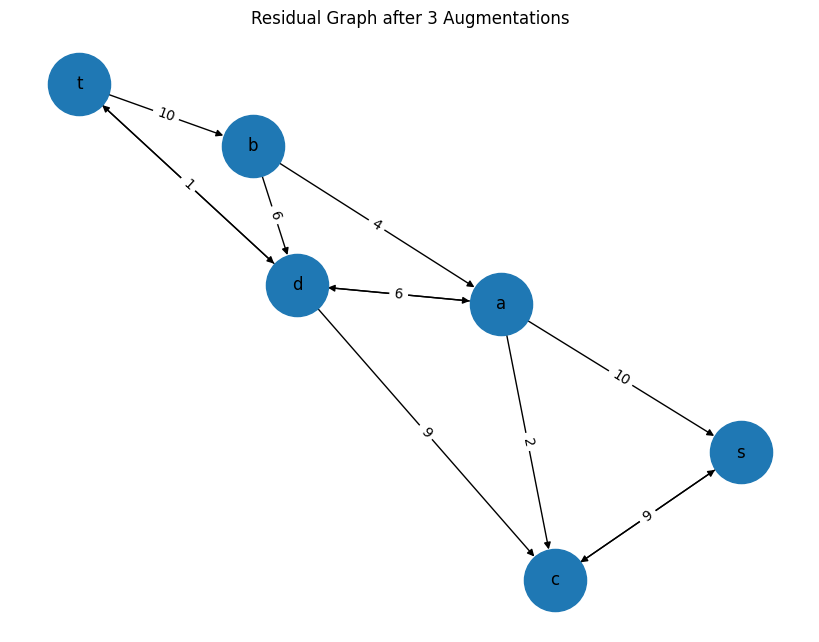

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Original graph (capacities)
edges = [
    ('s','a',10), ('s','c',10),
    ('a','b',4), ('b','t',10),
    ('c','d',9), ('d','t',10),
    ('a','d',8), ('d','b',6),
    ('a','c',2)
]

# Final flow after the 3 paths:
# 1) s-c-d-t : 9
# 2) s-a-b-t : 4
# 3) s-a-d-b-t : 6
flow = {
    ('s','c'): 9,
    ('c','d'): 9,
    ('d','t'): 9,

    ('s','a'): 10,
    ('a','b'): 4,
    ('b','t'): 10,

    ('a','d'): 6,
    ('d','b'): 6
}

# Build residual graph
R = nx.DiGraph()

for u, v, cap in edges:
    f = flow.get((u, v), 0)

    # Forward residual edge
    if cap - f > 0:
        R.add_edge(u, v, label=str(cap - f))

    # Backward residual edge
    if f > 0:
        R.add_edge(v, u, label=str(f))

# Draw residual graph
pos = nx.spring_layout(R, seed=42)
plt.figure(figsize=(8,6))
nx.draw(R, pos, with_labels=True, node_size=2000)
nx.draw_networkx_edge_labels(
    R, pos,
    edge_labels=nx.get_edge_attributes(R, 'label')
)
plt.title("Residual Graph after 3 Augmentations")
plt.show()


## Residual Graph after 3 steps

- Forward edges = remaining capacity

- Backward edges = how much flow can be undone

There is no path from ``s`` to ``t``, so the flow (19) is maximal

# Suboptimal path choice

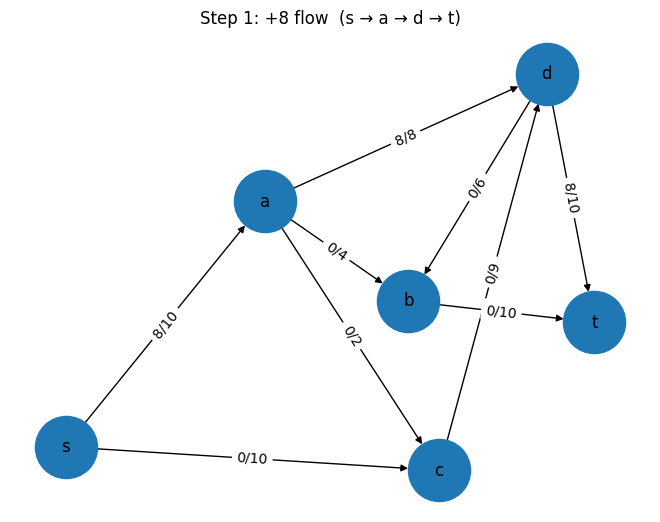

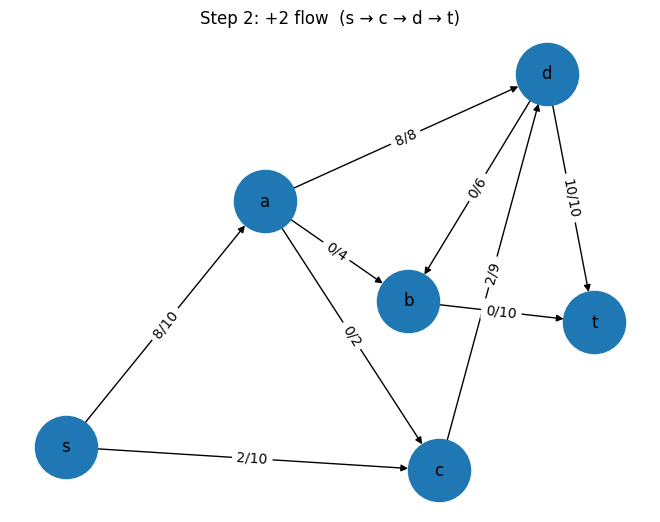

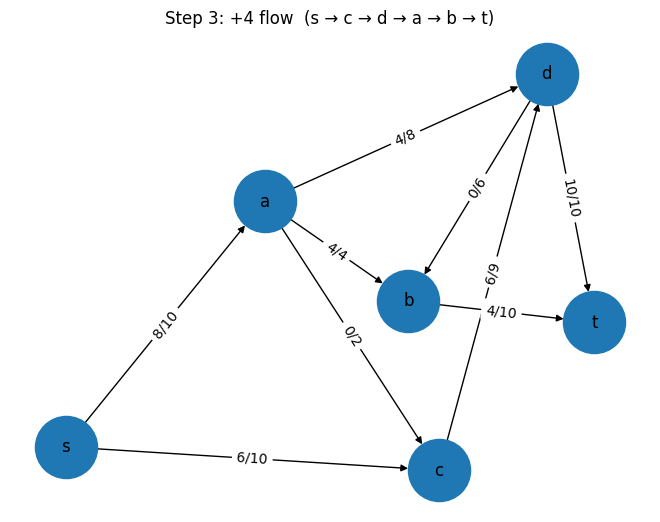

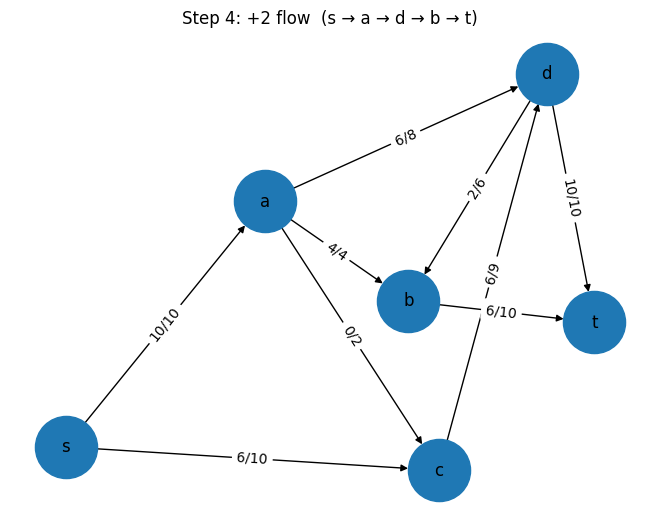

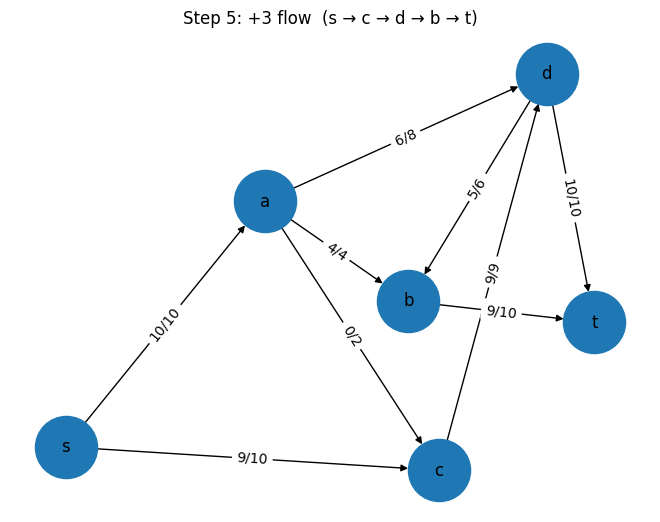

In [35]:
flow1 = {
    ('s','a'): 8,
    ('a','d'): 8,
    ('d','t'): 8
}

draw(flow1, "Step 1: +8 flow  (s → a → d → t)")

flow2 = {
    ('s','a'): 8,
    ('a','d'): 8,
    ('d','t'): 10,
    ('s','c'): 2,
    ('c','d'): 2
}

draw(flow2, "Step 2: +2 flow  (s → c → d → t)")

flow3 = {
    ('s','a'): 8,
    ('a','d'): 4,     # 8 - 4 (backward)
    ('d','t'): 10,
    ('s','c'): 6,
    ('c','d'): 6,
    ('a','b'): 4,
    ('b','t'): 4
}

draw(flow3, "Step 3: +4 flow  (s → c → d → a → b → t)")

flow4 = {
    ('s','a'): 10,
    ('a','d'): 6,
    ('d','t'): 10,
    ('s','c'): 6,
    ('c','d'): 6,
    ('a','b'): 4,
    ('d','b'): 2,
    ('b','t'): 6
}

draw(flow4, "Step 4: +2 flow  (s → a → d → b → t)")

flow5 = {
    ('s','a'): 10,
    ('a','d'): 6,
    ('d','t'): 10,
    ('s','c'): 9,
    ('c','d'): 9,
    ('a','b'): 4,
    ('d','b'): 5,
    ('b','t'): 9
}

draw(flow5, "Step 5: +3 flow  (s → c → d → b → t)")


## Edmonds-Karp algorithm

Edmonds–Karp is Ford–Fulkerson where the augmenting path is always chosen as the shortest (fewest edges) path using BFS on the residual graph.


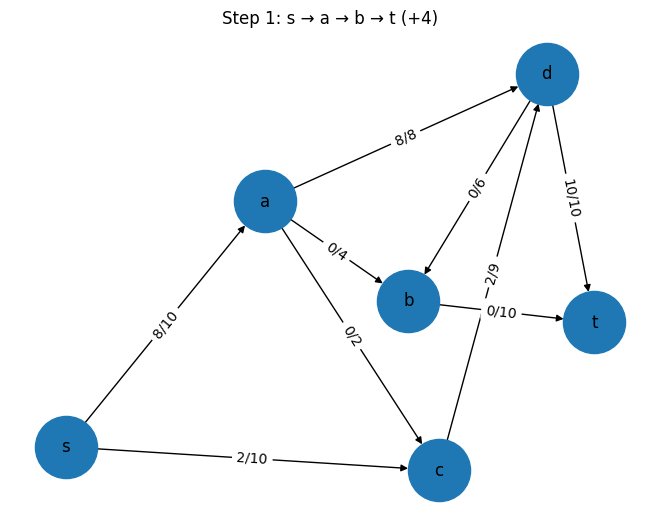

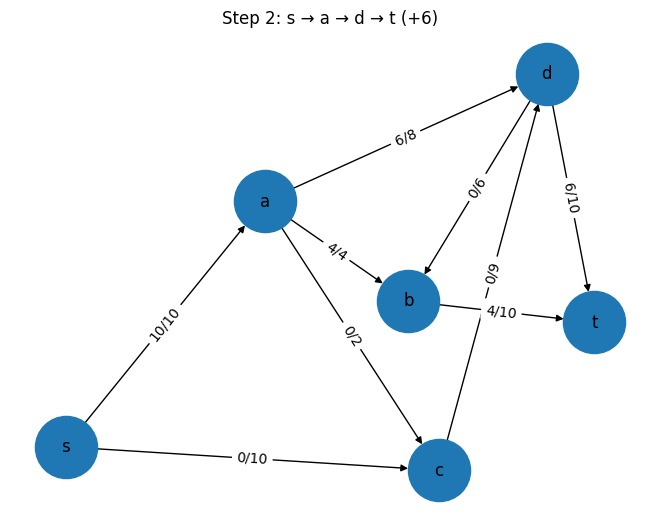

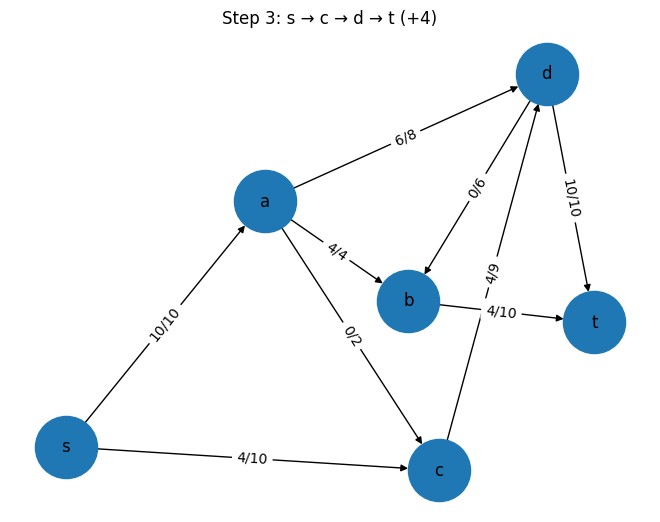

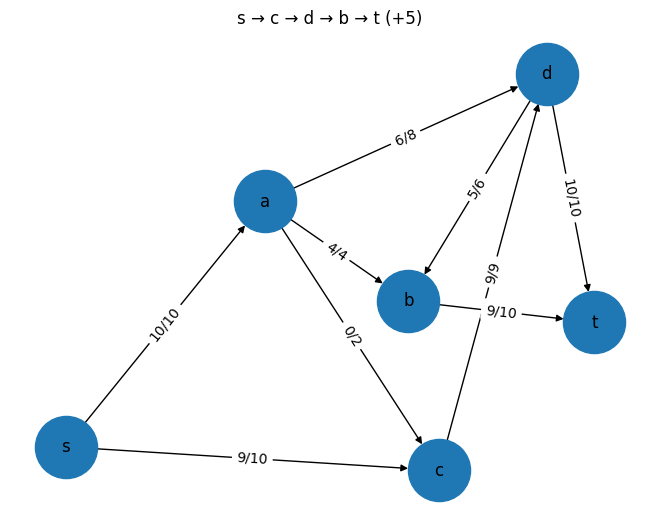

In [36]:
flow1 = {
    ('s','a'): 4,
    ('a','b'): 4,
    ('b','t'): 4
}
draw(flow2, "Step 1: s → a → b → t (+4)")
flow2 = {
    ('s','a'): 10,
    ('a','b'): 4,
    ('b','t'): 4,
    ('a','d'): 6,
    ('d','t'): 6
}
draw(flow2, "Step 2: s → a → d → t (+6)")
flow3 = {
    ('s','a'): 10,
    ('a','b'): 4,
    ('b','t'): 4,
    ('a','d'): 6,
    ('d','t'): 10,
    ('s','c'): 4,
    ('c','d'): 4
}
draw(flow3, "Step 3: s → c → d → t (+4)")
flow4 = {
    ('s','a'): 10,
    ('a','b'): 4,
    ('b','t'): 9,
    ('a','d'): 6,
    ('d','t'): 10,
    ('s','c'): 9,
    ('c','d'): 9,
    ('d','b'): 5
}
draw(flow4, "s → c → d → b → t (+5)")
